In [2]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from astropy.table import Table
from metric_tools import *
from sklearn.externals import joblib

%matplotlib inline
sns.set(style="white", color_codes=True, context="notebook", font_scale=1.4)

mainpath = '/Users/jorgetil/Astro/HITS'

In [3]:
table_file = '%s/tables/Blind15A_features_pointlike_cleanphot_cleanCCD.csv'\
              %(mainpath)
target_set = pd.read_csv(table_file)
target_set = target_set.set_index('internalID')
#print target_set.info()

/Users/jorgetil/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
print target_set.shape
target_set.head()

(1785771, 74)


,raMedian,decMedian,X,Y,ID,spCl,subClass,Var_Type,Var_subType,Amplitude,...,Rcs,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,g-i,g-r,r-i
internalID,,,,,,,,,,,,,,,,,,,,,
Blind15A_01_N1_1858_0066,137.295362,-6.438296,1858.364977,66.339016,NaN,NaN,NaN,NaN,NaN,0.246934,...,0.212511,0.055815,0.002645,-0.217172,0.139378,0.813768,0.838620,NaN,1.738221,NaN
Blind15A_01_N1_1981_0059,137.294797,-6.447314,1981.926146,59.229543,NaN,NaN,NaN,NaN,NaN,0.146267,...,0.270472,-0.555773,0.002645,1.380048,0.085489,0.796699,0.756664,NaN,1.375847,NaN
Blind15A_01_N1_1399_0063,137.295354,-6.404807,1399.726556,63.992543,NaN,NaN,NaN,NaN,NaN,0.516308,...,0.269067,1.255468,0.002644,4.633947,0.219478,0.707516,0.849094,NaN,0.958986,NaN
Blind15A_01_N1_0980_0085,137.297078,-6.374182,980.226219,85.415404,NaN,NaN,NaN,NaN,NaN,0.176617,...,0.229763,0.245815,0.002645,-1.196125,0.120753,0.895790,0.773958,NaN,1.071335,NaN
Blind15A_01_N1_1073_0070,137.295966,-6.380987,1073.490700,70.730140,NaN,NaN,NaN,NaN,NaN,0.503669,...,0.259250,0.912604,0.067399,1.365176,0.278343,0.729423,0.657703,NaN,1.450154,NaN


In [5]:
print 'original shape:', target_set.shape
cols = target_set.columns.values
FATS_feats_all = cols[9:]
FATS_feats_gr = FATS_feats_all[(FATS_feats_all != 'g-i') & (FATS_feats_all != 'r-i')]
FATS_feats_non = cols[9:-3]
FATS_feats_non_mean = FATS_feats_non[(FATS_feats_non != 'Mean') & 
                                     (FATS_feats_non != 'CAR_mean') & 
                                     (FATS_feats_non != 'Meanvariance') &
                                     (FATS_feats_non != 'Q31')]
print FATS_feats_non_mean

top_Feats = ['Period_fit', 'CAR_sigma', 'CAR_tau', 'PeriodLS']
print top_Feats

original shape: (1785771, 74)
['Amplitude' 'AndersonDarling' 'Autocor_length' 'Beyond1Std' 'CAR_sigma'
 'CAR_tau' 'Con' 'Eta_e' 'FluxPercentileRatioMid20'
 'FluxPercentileRatioMid35' 'FluxPercentileRatioMid50'
 'FluxPercentileRatioMid65' 'FluxPercentileRatioMid80'
 'Freq1_harmonics_amplitude_0' 'Freq1_harmonics_amplitude_1'
 'Freq1_harmonics_amplitude_2' 'Freq1_harmonics_amplitude_3'
 'Freq1_harmonics_rel_phase_0' 'Freq1_harmonics_rel_phase_1'
 'Freq1_harmonics_rel_phase_2' 'Freq1_harmonics_rel_phase_3'
 'Freq2_harmonics_amplitude_0' 'Freq2_harmonics_amplitude_1'
 'Freq2_harmonics_amplitude_2' 'Freq2_harmonics_amplitude_3'
 'Freq2_harmonics_rel_phase_0' 'Freq2_harmonics_rel_phase_1'
 'Freq2_harmonics_rel_phase_2' 'Freq2_harmonics_rel_phase_3'
 'Freq3_harmonics_amplitude_0' 'Freq3_harmonics_amplitude_1'
 'Freq3_harmonics_amplitude_2' 'Freq3_harmonics_amplitude_3'
 'Freq3_harmonics_rel_phase_0' 'Freq3_harmonics_rel_phase_1'
 'Freq3_harmonics_rel_phase_2' 'Freq3_harmonics_rel_phase_3' 'Gs

In [6]:
target_set_non = target_set.dropna(subset=FATS_feats_non)
target_set_non = target_set_non[target_set_non.Var_Type.isnull()]
target_set_non.sort_index(inplace=True)

target_set_all = target_set.dropna(subset=FATS_feats_all)
target_set_all = target_set_all[target_set_all.Var_Type.isnull()]
target_set_all.sort_index(inplace=True)

In [7]:
print target_set.shape
print target_set_all.shape
print target_set_non.shape

(1785771, 74)
(1092797, 74)
(1782933, 74)


In [10]:
RFC_multi_DA = joblib.load('%s/models/RFC_all_multiclass.pkl' % (mainpath))
RFC_multi_DAall_sw = joblib.load('%s/models/RFC_all_multiclass_DAall_sampleweight.pkl' % (mainpath))
RFC_multi_DAall_bcw = joblib.load('%s/models/RFC_all_multiclass_DAall_balancedclassweight.pkl' % (mainpath))
RFC_multi_DAall_mean = joblib.load('%s/models/RFC_all_multiclass_DAall_balancedclassweight_nonMean.pkl' % (mainpath))
RFC_multi_DAall_top10 = joblib.load('%s/models/RFC_all_multiclass_DAall_balancedclassweight_top10.pkl' % (mainpath))

In [11]:
Pred_Var_Type = []
prob_target = []
chunks = range(0,len(target_set_non), 10000)
use_feat = FATS_feats_non

for kk in range(len(chunks)-1):
    print chunks[kk],':',chunks[kk+1],'|',
    Pred_Var_Type__ = RFC_multi_DAall_bcw.predict(target_set_non.iloc[chunks[kk]:chunks[kk+1]][use_feat])
    prob_target__ = RFC_multi_DAall_bcw.predict_proba(target_set_non.iloc[chunks[kk]:chunks[kk+1]][use_feat])
    Pred_Var_Type.extend(Pred_Var_Type__)
    prob_target.extend(prob_target__)
    #if kk == 1: break
        
print chunks[kk+1],':',len(target_set_non)
Pred_Var_Type__ = RFC_multi_DAall_bcw.predict(target_set_non.iloc[chunks[kk+1]:][use_feat])
prob_target__ = RFC_multi_DAall_bcw.predict_proba(target_set_non.iloc[chunks[kk+1]:][use_feat])
Pred_Var_Type.extend(Pred_Var_Type__)
prob_target.extend(prob_target__)

Pred_Var_Type = np.asarray(Pred_Var_Type)
prob_target = np.asarray(prob_target)

print Pred_Var_Type.shape
print prob_target.shape

0 : 10000 | 10000 : 20000 | 20000 : 30000 | 30000 : 40000 | 40000 : 50000 | 50000 : 60000 | 60000 : 70000 | 70000 : 80000 | 80000 : 90000 | 90000 : 100000 | 100000 : 110000 | 110000 : 120000 | 120000 : 130000 | 130000 : 140000 | 140000 : 150000 | 150000 : 160000 | 160000 : 170000 | 170000 : 180000 | 180000 : 190000 | 190000 : 200000 | 200000 : 210000 | 210000 : 220000 | 220000 : 230000 | 230000 : 240000 | 240000 : 250000 | 250000 : 260000 | 260000 : 270000 | 270000 : 280000 | 280000 : 290000 | 290000 : 300000 | 300000 : 310000 | 310000 : 320000 | 320000 : 330000 | 330000 : 340000 | 340000 : 350000 | 350000 : 360000 | 360000 : 370000 | 370000 : 380000 | 380000 : 390000 | 390000 : 400000 | 400000 : 410000 | 410000 : 420000 | 420000 : 430000 | 430000 : 440000 | 440000 : 450000 | 450000 : 460000 | 460000 : 470000 | 470000 : 480000 | 480000 : 490000 | 490000 : 500000 | 500000 : 510000 | 510000 : 520000 | 520000 : 530000 | 530000 : 540000 | 540000 : 550000 | 550000 : 560000 | 560000 : 570000

In [12]:
prob_target = pd.DataFrame(prob_target, index=target_set_non.index, columns=RFC_multi_DAall_mean.classes_)
prob_target['Pred_Var_Type'] = Pred_Var_Type
#prob_target.to_csv('%s/tables/Blind15A_all_candidates_from_RFC_multi_DAall_bcw_nonMean.csv'
#                        % (mainpath))
prob_target.head()

,CV,DSCT,EB,NV,QSO,ROTVAR,RRLYR,SNe,Pred_Var_Type
internalID,,,,,,,,,
Blind15A_01_N10_0030_3303,0.223510,0.024559,0.000,0.232619,0.516140,0.002957,0.000215,0.0,QSO
Blind15A_01_N10_0033_0287,0.000000,0.024357,0.000,0.781414,0.143833,0.000156,0.050239,0.0,NV
Blind15A_01_N10_0033_2018,0.046320,0.000000,0.025,0.142688,0.773964,0.000000,0.012028,0.0,QSO
Blind15A_01_N10_0043_0753,0.317996,0.000000,0.000,0.225558,0.455554,0.000000,0.000893,0.0,QSO
Blind15A_01_N10_0047_1151,0.253444,0.000000,0.025,0.135909,0.542906,0.042741,0.000000,0.0,QSO


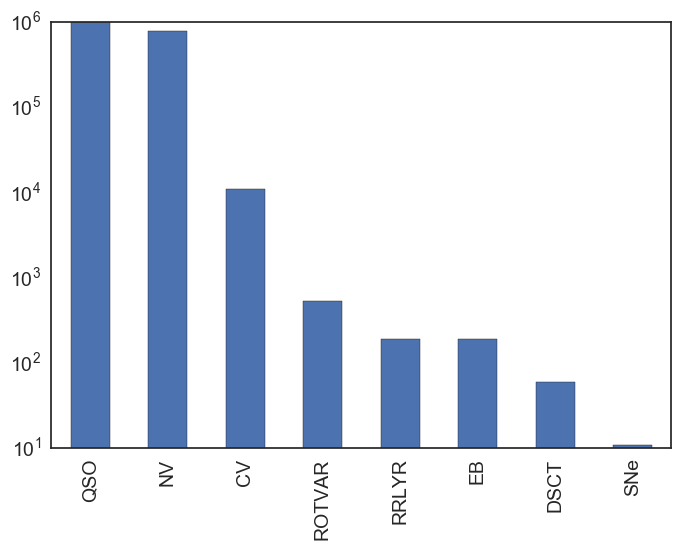

In [13]:
prob_target.Pred_Var_Type.value_counts().plot(kind="bar")
plt.yscale('log')
plt.show()

In [158]:
RFC_multi_DAall_mean.n_features_

58

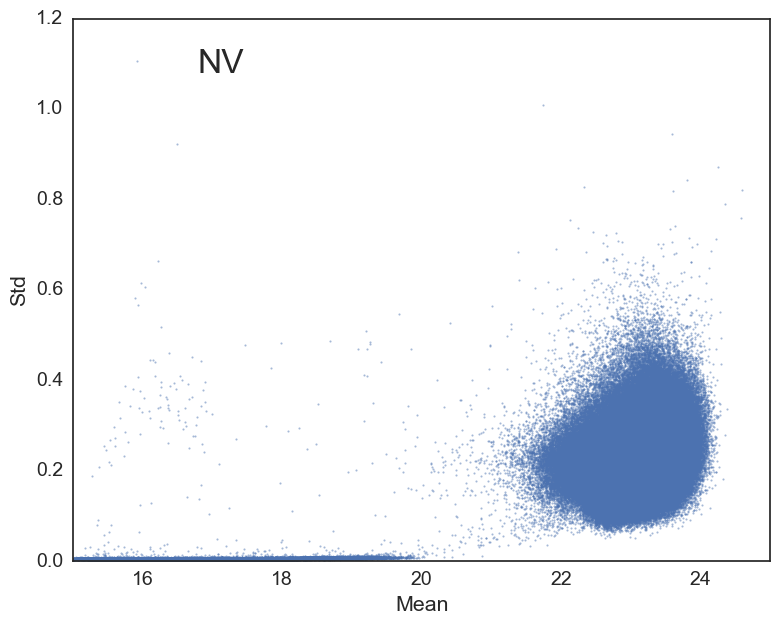

In [16]:
plt.figure(figsize=(9,7))
#plt.plot(target_set_non[Pred_Var_Type=='QSO'].Mean, 
#         target_set_non[Pred_Var_Type=='QSO'].Std, 'r.', alpha=.5, ms=3, label='QSO')
plt.plot(target_set_non[Pred_Var_Type=='NV'].Mean, 
         target_set_non[Pred_Var_Type=='NV'].Std, 'b.', alpha=.5, ms=3, label='NV')
#plt.plot(target_set_non[Pred_Var_Type=='DSCT'].Mean, 
#         target_set_non[Pred_Var_Type=='DSCT'].Std, 'g.', alpha=.5, ms=3, label='DSCT')
#plt.plot(target_set_non[Pred_Var_Type=='RRLYR'].Mean, 
#         target_set_non[Pred_Var_Type=='RRLYR'].Std, 'c*', alpha=.7, ms=7, label='RRLYR')
#plt.plot(target_set_non[Pred_Var_Type=='EB'].Mean, 
#         target_set_non[Pred_Var_Type=='EB'].Std, 'k*', alpha=.7, ms=7, label='EB')
#plt.plot(target_set_non[Pred_Var_Type=='ROTVAR'].Mean, 
#         target_set_non[Pred_Var_Type=='ROTVAR'].Std, 'y*', alpha=.7, ms=7, label='ROTVAR')
plt.legend(loc='upper left', fontsize='x-large')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.xlim(15,25)
plt.show()

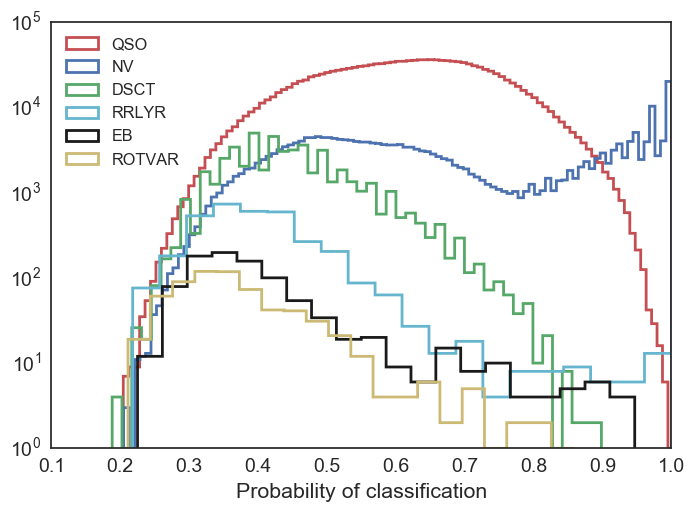

In [97]:
plt.hist(prob_target.query('Pred_Var_Type=="QSO"').QSO.values,
         bins=100, histtype='step', color='r', lw=2, label='QSO')
plt.hist(prob_target.query('Pred_Var_Type=="NV"').NV.values,
         bins=100, histtype='step', color='b', lw=2, label='NV')
plt.hist(prob_target.query('Pred_Var_Type=="DSCT"').DSCT.values,
         bins=50, histtype='step', color='g', lw=2, label='DSCT')
plt.hist(prob_target.query('Pred_Var_Type=="RRLYR"').RRLYR.values,
         bins=20, histtype='step', color='c', lw=2, label='RRLYR')
plt.hist(prob_target.query('Pred_Var_Type=="EB"').EB.values,
         bins=20, histtype='step', color='k', lw=2, label='EB')
plt.hist(prob_target.query('Pred_Var_Type=="ROTVAR"').ROTVAR.values,
         bins=20, histtype='step', color='y', lw=2, label='ROTVAR')
plt.xlabel('Probability of classification')
plt.legend(loc='upper left', fontsize='x-small')
plt.yscale('log')
plt.show()

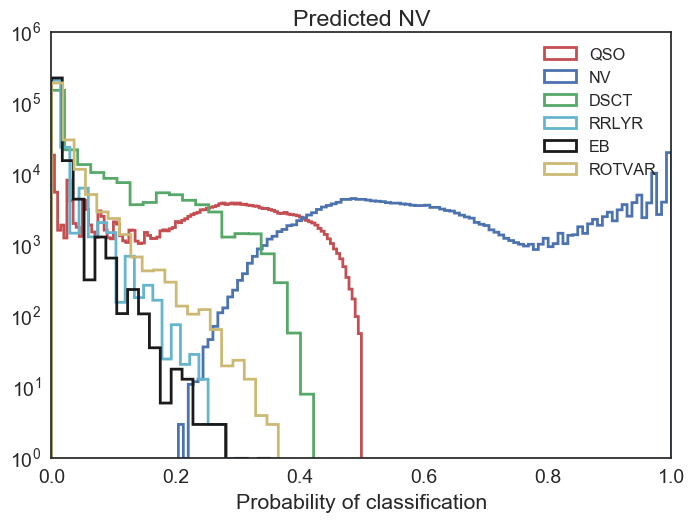

In [98]:
plt.title('Predicted NV')
plt.hist(prob_target.query('Pred_Var_Type=="NV"').QSO.values,
         bins=100, histtype='step', color='r', lw=2, label='QSO')
plt.hist(prob_target.query('Pred_Var_Type=="NV"').NV.values,
         bins=100, histtype='step', color='b', lw=2, label='NV')
plt.hist(prob_target.query('Pred_Var_Type=="NV"').DSCT.values,
         bins=20, histtype='step', color='g', lw=2, label='DSCT')
plt.hist(prob_target.query('Pred_Var_Type=="NV"').RRLYR.values,
         bins=20, histtype='step', color='c', lw=2, label='RRLYR')
plt.hist(prob_target.query('Pred_Var_Type=="NV"').EB.values,
         bins=20, histtype='step', color='k', lw=2, label='EB')
plt.hist(prob_target.query('Pred_Var_Type=="NV"').ROTVAR.values,
         bins=20, histtype='step', color='y', lw=2, label='ROTVAR')
plt.xlabel('Probability of classification')
plt.legend(loc='best', fontsize='x-small')
plt.yscale('log')
plt.show()